In [1]:
import labeled_functions
import numpy as np
import pandas as pd

import keras
from keras import regularizers
from keras.layers import Dense, Embedding, Flatten, Dropout
from keras.models import Model, Input
from keras.preprocessing.text import text_to_word_sequence, one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

import sklearn as sk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import stop_words
from sklearn.model_selection import train_test_split, StratifiedKFold

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
X, y = labeled_functions.load_labeled_neutrals(path=r"./../../Fall_18/edu/active_learning/")

Labeled Data loaded.


In [3]:
# Vectorize using CountVectorizer
token = r"(?u)\b[\w\'/]+\b"
def vectorize(ngram=(1,1), stop=["the","a","of","and","br","to"]):
    return CountVectorizer(token_pattern=token, binary=True, ngram_range=ngram, stop_words=stop)

vectorizer = vectorize(stop=["a","of","and","br","to"])
X_vector = vectorizer.fit_transform(X)


X_train_vector , X_test_vector, y_train, y_test = train_test_split(X_vector, y, test_size=1./3, random_state=42)

In [4]:
y_cat = to_categorical(y,num_classes=3)
y_cat[:5]

array([[0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.]], dtype=float32)

In [5]:
# Maximum sequence length
X_sequence = []
for i in X:
    X_sequence.append(text_to_word_sequence(i))
max_length = len(max(X_sequence,key=len))

X_corpus_one_hot = []
for i in X:
    X_corpus_one_hot.append(one_hot(i, round(max_length*1.1)))

X_corpus_one_hot[1:3]

[[32, 99, 56, 100, 32, 5, 94, 120, 11], [60, 98, 24, 60, 75, 32, 1]]

In [6]:
X_train_sequence, X_test_sequence, y_train, y_test = train_test_split(X_sequence, y_cat, test_size=1./3, random_state=42)

In [7]:
X_train_sequence[0]

['who',
 "'s",
 'liked',
 'marc',
 'bolan',
 'but',
 'gives',
 'a',
 'fascinating',
 'insight',
 'into',
 'the',
 'era',
 'these',
 'were',
 'the',
 'time']

In [8]:
# padded_seq = pad_sequences(X_corpus_one_hot)
# X_train_padded_seq, X_test_padded_seq, y_train, y_test = train_test_split(padded_seq, y_cat,
#                                                                           test_size=1./3, random_state=42)
padded_seq = pad_sequences(X_corpus_one_hot)
X_train_padded_seq, X_test_padded_seq, y_train, y_test = train_test_split(padded_seq, y_cat,
                                                                          test_size=1./3, random_state=42)

In [9]:
X_train_padded_seq.shape, X_test_padded_seq.shape, y.shape

((3644, 134), (1823, 134), (5467,))

In [10]:
# Creating validation data 
X_test_core, X_val, y_test_core, y_val = train_test_split(X_test_padded_seq, y_test, test_size=0.2, random_state=42)

In [11]:
# Model setup
input_nodes= Input(shape=(X_train_padded_seq.shape[1],))
e = Embedding(round(max_length*1.1),
              100,
              input_length=X_train_padded_seq.shape[1],
              trainable=True)(input_nodes)
flat= Flatten()(e)
dense1 = Dense(100, activation='tanh', kernel_regularizer=regularizers.l2(0.1))(flat)
drop = Dropout(0.2)(dense1)
dense2 = Dense(10, activation='tanh')(drop)
drop2 = Dropout(0.2)(dense2)

# dense2 = Dense(30, activation='sigmoid')(dense1)

output_nodes=Dense(3, activation='softmax')(drop2)
# output_nodes=Dense(1, activation='sigmoid')(dense1)

#Build model
model = Model(inputs=input_nodes, outputs=output_nodes)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
model.fit(X_train_padded_seq, y_train, batch_size=64, epochs=15, validation_data=(X_val,y_val))

Train on 3644 samples, validate on 365 samples
Epoch 1/15
3644/3644 [==============================] - 2s 672us/step - loss: 3.4392 - acc: 0.3576 - val_loss: 1.1311 - val_acc: 0.3288
Epoch 2/15
3644/3644 [==============================] - 2s 528us/step - loss: 1.1120 - acc: 0.3867 - val_loss: 1.1079 - val_acc: 0.3753
Epoch 3/15
3644/3644 [==============================] - 2s 639us/step - loss: 1.0972 - acc: 0.4380 - val_loss: 1.1027 - val_acc: 0.4521
Epoch 4/15
3644/3644 [==============================] - 2s 542us/step - loss: 1.0901 - acc: 0.4673 - val_loss: 1.1206 - val_acc: 0.4055
Epoch 5/15
3644/3644 [==============================] - 2s 510us/step - loss: 1.0977 - acc: 0.4838 - val_loss: 1.1313 - val_acc: 0.4411
Epoch 6/15
3644/3644 [==============================] - 2s 460us/step - loss: 1.1013 - acc: 0.4929 - val_loss: 1.1489 - val_acc: 0.4411
Epoch 7/15
3644/3644 [==============================] - 2s 466us/step - loss: 1.0900 - acc: 0.5104 - val_loss: 1.1471 - val_acc: 0.4055
E

In [13]:
model.evaluate(X_test_padded_seq, y_test)

1823/1823 [==============================] - 0s 177us/step


[1.3162805498529122, 0.465715853218449]

- __confusion_matrix__

Which elements is the models confused?
Pos-Net-Neg

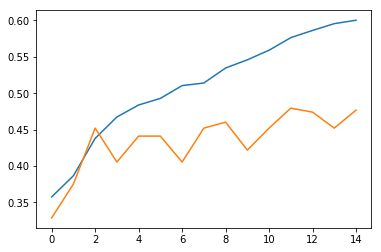

In [14]:
plt.plot(model.history.history['acc'])
plt.plot(model.history.history['val_acc'])
plt.show()